In [1]:
import tqdm

import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import scipy.interpolate as interpolate

from fiesta.train.DataManager import DataManager
from fiesta.train.AfterglowData import RunPyblastafterglow

file = "./model/pyblastafterglow_raw_data.h5"
fix_file = "./model/fix_file_3.h5"

In [2]:
with h5py.File(fix_file, "r") as f:
    problematic_train_X = f["train"]["X"][:]
    problematic_val_X = f["val"]["X"][:]
    #problematic_test_X = f["test"]["X"][:]

    problematic_val_y = f["val"]["y"][:]

    
    print("train is nan? inf?", np.any(np.isnan(f["train"]["y"])), np.any(np.isinf(f["train"]["y"])))
    print("val is nan? inf?", np.any(np.isnan(f["val"]["y"])), np.any(np.isinf(f["val"]["y"])))
    #print("test is nan? inf?", np.any(np.isnan(f["test"]["y"])), np.any(np.isinf(f["test"]["y"])))


train is nan? inf? True True
val is nan? inf? False True


In [3]:
with h5py.File(fix_file, "r") as f:
    train_nans = np.unique(np.where(np.isnan(f["train"]["y"]))[0])

len(train_nans)

11

In [4]:
def find_old_ind(X_old, X):

    inds = []

    for x in X:
        inds.append(np.where(X_old == x)[0][0])
    
    return np.array(inds)


with h5py.File(file, "r") as f:
    problematic_train_ind = find_old_ind(f["train"]["X"][:], problematic_train_X)
    problematic_val_ind = find_old_ind(f["val"]["X"][:], problematic_val_X)


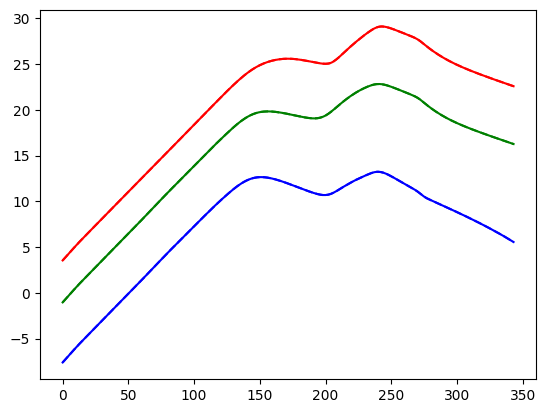

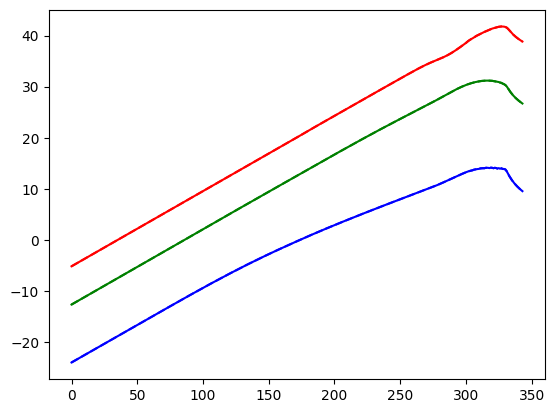

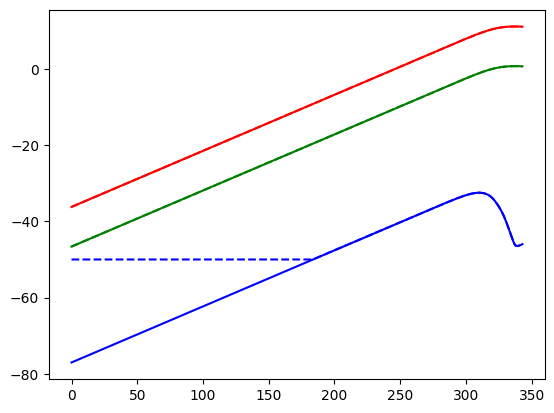

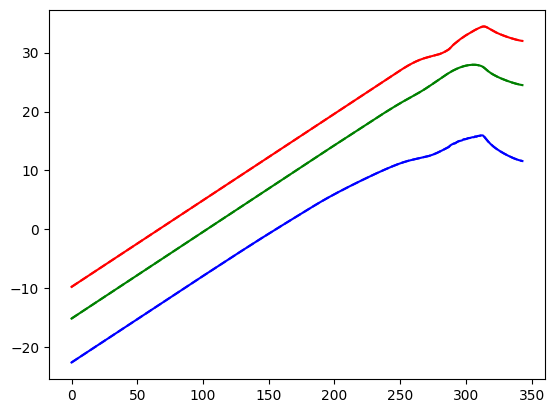

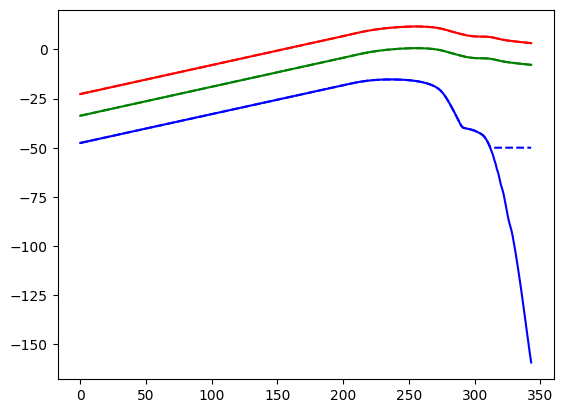

In [19]:
with h5py.File(file, "r+") as f:
    
    y_old = f["train"]["y"][np.sort(problematic_train_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["train"]["y"][:])[np.argsort(problematic_train_ind)].reshape(-1, 256, 344)

    nan_inds = np.isnan(y_new[:,0,0])
    #interp_nans = interpolate.interp1d(x=np.log10(f["times"][:94]), y=y_old[nan_inds,:,:94], axis=-1, fill_value="extrapolate")
    #y_without_nans = interp_nans(np.log10(f["times"][94:150]))
    for j in [5,6,7,8,9]:
        plt.plot(y_old[j, 0, :], linestyle="dashed", color="red")
        plt.plot(y_new[j, 0, :], linestyle="solid", color="red")

        plt.plot(y_old[j, 125, :], linestyle="dashed", color = "green")
        plt.plot(y_new[j, 125, :], linestyle="solid", color="green")

        plt.plot(y_old[j, -1, :], linestyle="dashed", color = "blue")
        plt.plot(y_new[j, -1, :], linestyle="solid", color="blue")
        #plt.plot(y_old[nan_inds,0,:][j], linestyle="dashed")
        #plt.show()
        #xx = int(input(f"Enter the end index:" ))
        #y_old[np.where(nan_inds)[0][j],:, 94:xx] = y_without_nans[j,:,:xx-94]
        #plt.plot(y_old[nan_inds,0,:][j])
        plt.show()

## OVERWRITE

In [ ]:
with h5py.File(file, "r+") as f:
    
    y_old = f["train"]["y"][np.sort(problematic_train_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["train"]["y"][:])[np.argsort(problematic_train_ind)].reshape(-1, 256, 344)
    y_new = np.maximum(-50, y_new)

    nan_inds = np.isnan(y_new[:,0,0])
    #interp_nans = interpolate.interp1d(x=np.log10(f["times"][:94]), y=y_old[nan_inds,:,:94], axis=-1, fill_value="extrapolate")
    #y_without_nans = interp_nans(np.log10(f["times"][94:160]))
    
    y_old[~nan_inds,:,:] = y_new[~nan_inds,:,:]

    f["train"]["y"][np.sort(problematic_train_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

In [23]:
with h5py.File(file, "r+") as f:
    
    y_old = f["val"]["y"][np.sort(problematic_val_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["val"]["y"][:])[np.argsort(problematic_val_ind)].reshape(-1, 256, 344)
    nan_inds = np.isnan(y_new[:,0,0])
   
    y_new = np.maximum(-50, y_new)
    y_old[~nan_inds,:,:] = y_new[~nan_inds,:,:]

    f["val"]["y"][np.sort(problematic_val_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

## Check overwritten h5 file

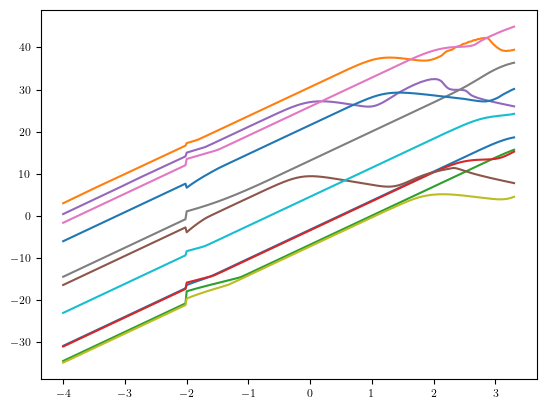

In [55]:
with h5py.File(file) as f:
    
    times = f["times"][:]
    nus = f["nus"][:]

    problematic_ind = np.where(np.abs(f["train"]["y"][:, 94] - f["train"]["y"][:, 93])>0.33)[0]
    problematic_train_X = f["train"]["X"][problematic_ind]

    for ind in problematic_ind:
        plt.plot(np.log10(f["times"][:]), f["train"]["y"][ind,:344])


In [60]:
problematic_train_X[:,-1]

array([162.14814002, 124.0202407 , 156.74042156, 267.51542657,
       258.46077026, 174.54770705, 261.6925724 , 126.7336299 ,
       262.69070846, 143.13137125, 124.8276274 ])

In [64]:

pbag = RunPyblastafterglow(jet_type=0,
                           times=times,
                           nus=nus[:2],
                           parameter_names=["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "Gamma0"],
                           X = problematic_train_X,
                           tb0=1e-4,
                           tb1=1e10,
                           ntb=1500,
                           path_to_exec="/home/aya/work/hkoehn/fiesta/PyBlastAfterglowMag/src/pba.out",
                           loglevel="info")
_, log_mJys = pbag(0)

[ INFO    ] : [ main.cpp:149 ] : Computation tgrid = [0.0001, 9.78738e+09] n=1500
[ INFO    ] : [ main.cpp:151 ] : Output      tgrid = [0.0001, 9.78738e+09] n=1500
[ INFO    ] : [ model_magnetar.h:569 ] : Magnetar is not initialized and will not be considered.
 mom=160.606 Gamma=160.609 beta=0.999981
 mom=148.809 Gamma=148.813 beta=0.999977
 mom=127.768 Gamma=127.772 beta=0.999969
 mom=101.685 Gamma=101.69 beta=0.999952
 mom=75.0573 Gamma=75.064 beta=0.999911
 mom=51.4427 Gamma=51.4524 beta=0.999811
 mom=32.813 Gamma=32.8282 beta=0.999536
 mom=19.5695 Gamma=19.595 beta=0.998697
 mom=11.0156 Gamma=11.0609 beta=0.995905
 mom=5.95784 Gamma=6.04118 beta=0.986205
 mom=3.18603 Gamma=3.33928 beta=0.954107
 mom=1.73814 Gamma=2.00528 beta=0.866784
[ INFO    ] : [ ejecta_id.h:220 ] :  1D ID has theta_wing=0.0354568 theta_core=0.0106634
[ INFO    ] : [ ejecta_id.h:279 ] : Initial data loaded with nshells=1 m_nlayers=12
[ INFO    ] : [ ejecta_id.h:301 ] : Angular grids are initialized. nshells=1 m

In [ ]:
log_mJys

(688,)

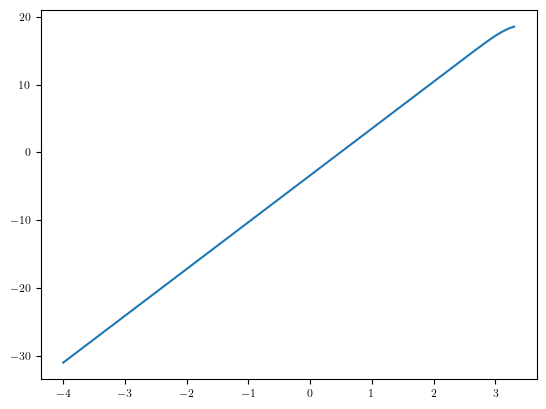

In [68]:
plt.plot(np.log10(times), log_mJys.reshape(2, len(times))[1] )


In [69]:
problematic_train_X[0]
    

array([ 1.23523756e+00,  5.67855938e+01,  1.06633921e-02,  3.32509819e+00,
       -5.54359899e+00,  2.72036658e+00, -4.83995873e-01, -5.35047969e+00,
        1.62148140e+02])